<div style="background-color:	#41e5d3; text-align:center; vertical-align: middle; padding:40px 0; margin-top:30px">
<h1 style="color:white">ML - Verhuuraantallen voorspellen</h1>
<b style="color:white">Jasper Duncker, Julia Boschman, Nima Agha Ghafar Hamedani</b>
    </div>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

# metrics etc
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error


### Bestanden importeren

In [33]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
Xtest = test.drop(['date_hour'],axis=1)
train["date_hour"]

0        2011-01-01 00:00:00
1        2011-01-01 01:00:00
2        2011-01-01 02:00:00
3        2011-01-01 03:00:00
4        2011-01-01 04:00:00
                ...         
16632    2012-11-30 19:00:00
16633    2012-11-30 20:00:00
16634    2012-11-30 21:00:00
16635    2012-11-30 22:00:00
16636    2012-11-30 23:00:00
Name: date_hour, Length: 16637, dtype: object

### TimeSeries

In [41]:
import pandas as pd
train['date_hour'] = pd.to_datetime(train['date_hour'])

# Voeg dag, week, maand, jaar
train['hour_of_day'] = train['date_hour'].dt.hour #Het uur van de dag (0-23).
train['day_of_week'] = train['date_hour'].dt.dayofweek #De dag van de week (maandag is 0, zondag is 6).
train['week'] = train['date_hour'].dt.isocalendar().week #De weken
train['month'] = train['date_hour'].dt.month
train['year'] = train['date_hour'].dt.year

#Time series / date functionality — pandas 2.1.1 documentation. (n.d.). https://pandas.pydata.org/docs/user_guide/timeseries.html

def get_season(month):
    if month in [3, 4, 5]:  
        return "Lente"
    elif month in [6, 7, 8]:  
        return "Zomer"
    elif month in [9, 10, 11]:
        return "Herfst"
    else: 
        return "Winter"

train['season'] = train['month'].apply(get_season)

train



,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt,hour_of_day,day_of_week,month,year,season,week
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16,0,5,1,2011,Winter,52
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40,1,5,1,2011,Winter,52
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32,2,5,1,2011,Winter,52
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13,3,5,1,2011,Winter,52
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1,4,5,1,2011,Winter,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16632,2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377,19,4,11,2012,Herfst,48
16633,2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245,20,4,11,2012,Herfst,48
16634,2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183,21,4,11,2012,Herfst,48
16635,2012-11-30 22:00:00,0,1,0.30,0.3333,0.75,0.0000,163,22,4,11,2012,Herfst,48


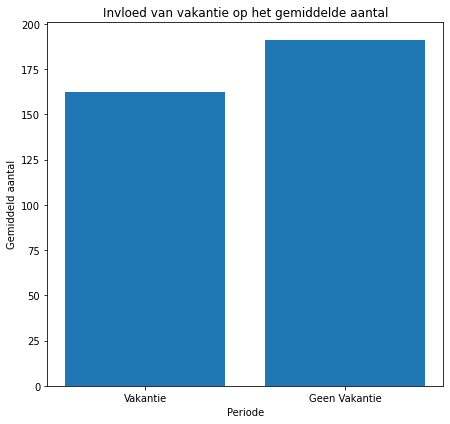

In [46]:
import pandas as pd
import matplotlib.pyplot as plt


#Invloed van vakantie op het gemiddelde aantal
holiday_data = train[train['holiday'] == 1]
non_holiday_data = train[train['holiday'] == 0]
holiday_avg = holiday_data['cnt'].mean()
non_holiday_avg = non_holiday_data['cnt'].mean()

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.bar(['Vakantie', 'Geen Vakantie'], [holiday_avg, non_holiday_avg])
plt.xlabel('Periode')
plt.ylabel('Gemiddeld aantal')
plt.title('Invloed van vakantie op het gemiddelde aantal')


plt.tight_layout()
plt.show()


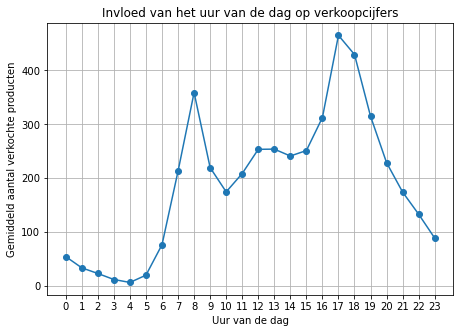

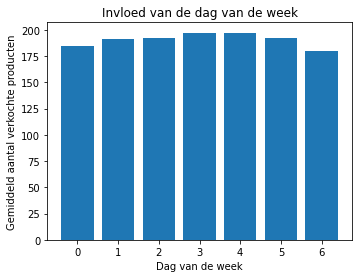

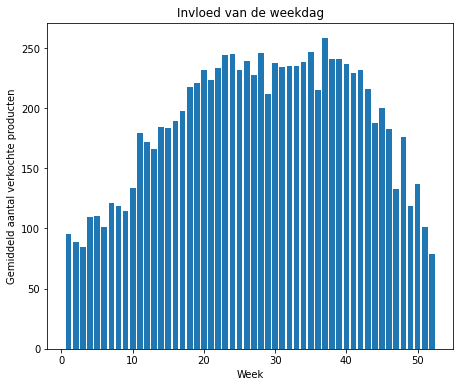

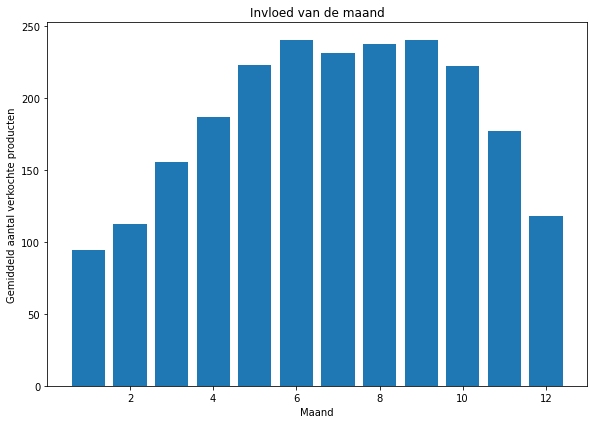

In [58]:

# Tweede grafiek: Invloed van het uur van de dag op verkoopcijfers
hourly_avg = train.groupby('hour_of_day')['cnt'].mean()
plt.figure(figsize=(16, 5))
plt.subplot(122)
plt.plot(hourly_avg.index, hourly_avg.values, marker='o')
plt.xlabel('Uur van de dag')
plt.ylabel('Gemiddeld aantal verkochte producten')
plt.title('Invloed van het uur van de dag op verkoopcijfers')
plt.xticks(range(24))
plt.grid(True)

# Invloed van de dag van de week op de verkoop

day_of_week_avg = train.groupby('day_of_week')['cnt'].mean()
plt.figure(figsize=(12, 4))
plt.subplot(122)
plt.bar(day_of_week_avg.index, day_of_week_avg.values)
plt.xlabel('Dag van de week')
plt.ylabel('Gemiddeld aantal verkochte producten')
plt.title('Invloed van de dag van de week')

# Invloed van de weekdag op de verkoop
plt.figure(figsize=(16, 6))

weekday_avg = train.groupby('week')['cnt'].mean()
plt.subplot(122)
plt.bar(weekday_avg.index, weekday_avg.values)
plt.xlabel('Week')
plt.ylabel('Gemiddeld aantal verkochte producten')
plt.title('Invloed van de weekdag')

# Invloed van de maand op de verkoop
plt.figure(figsize=(16, 6))

month_avg = train.groupby('month')['cnt'].mean()
plt.subplot(122)
plt.bar(month_avg.index, month_avg.values)
plt.xlabel('Maand')
plt.ylabel('Gemiddeld aantal verkochte producten')
plt.title('Invloed van de maand')

plt.tight_layout()
plt.show()


### EDA

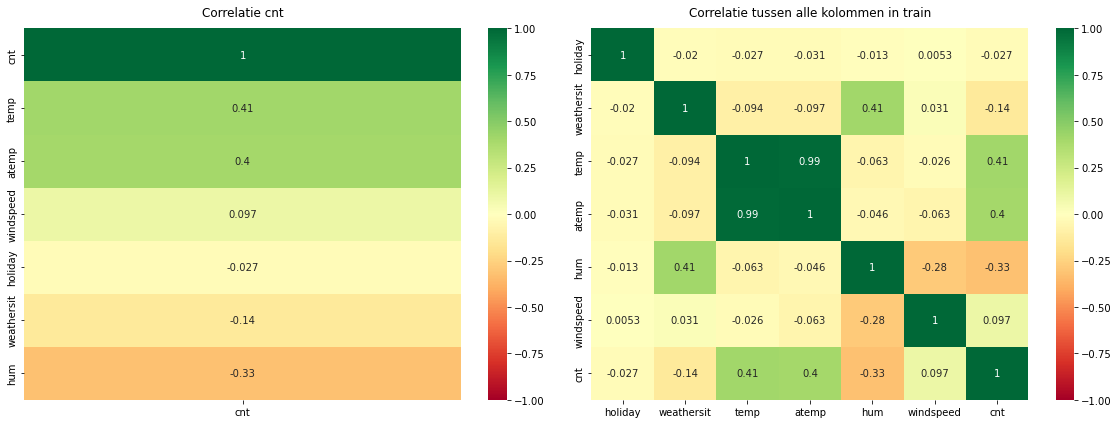

In [3]:
plt.figure(figsize=(16, 6))
plt.subplot(121)  
heatmap1 = sns.heatmap(train.corr(method='pearson')[['cnt']].sort_values(by='cnt', ascending=False),
                       vmin=-1, vmax=1, annot=True, cmap='RdYlGn')
heatmap1.set_title('Correlatie cnt', fontdict={'fontsize': 12}, pad=12)


plt.subplot(122) 
heatmap2 = sns.heatmap(train.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='RdYlGn')
heatmap2.set_title('Correlatie tussen alle kolommen in train', fontdict={'fontsize': 12}, pad=12)

plt.tight_layout()  
plt.show()

### Metric Functie

In [4]:
def train_test_model(model):
    """
    Traint het opgegeven model met behulp van de meegeleverde trainingsgegevens en evalueert het met de testgegevens.

    Parameters:
    ----------
    model : model vergelijkbaar met sklearn
        Het model dat getraind en geëvalueerd moet worden.
    
    Returns:
    -------
    RMSE :
        Deze functie drukt de RMSE score van het model op de testgegevens af.
    
        
    """

    model.fit(X_train,y_train)
    y_pred= model.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = MSE**0.5
    R2 = r2_score(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)
    return print('R2:',R2,
                 '\nMAE:', MAE,
                 '\nMSE:',MSE,
                 '\nRMSE:',RMSE)

### Train, test, split

In [5]:
from sklearn.model_selection import train_test_split
X = train.drop(['date_hour','cnt'],axis=1)
y = train['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=27)

### LinearReg

In [6]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

train_test_model(lin_reg)
lin_reg_pred = lin_reg.predict(Xtest)


R2: 0.26574843016938676 
MAE: 115.33913243900095 
MSE: 23816.522099910337 
RMSE: 154.3260253486441


### Randomforest

### Pushen Kaggle

In [19]:
def push_dataframe(p_id_values, predictions_values, push=True, csv_file_path=None):
    """
    Creëert een DataFrame met kolommen 'p_id' en 'predictions' en slaat het op naar een CSV-bestand (optioneel).

    Args:
        p_id_values (list): Een lijst met waarden voor de 'p_id'-kolom.
        predictions_values (list): Een lijst met waarden voor de 'predictions'-kolom.
        push (bool): Een boolean die aangeeft of het DataFrame moet worden opgeslagen naar een CSV-bestand.
        csv_file_path (str): Het pad naar het CSV-bestand waarin het DataFrame moet worden opgeslagen (alleen nodig als push=True).

    Returns:
        pd.DataFrame: Een DataFrame met de opgegeven kolommen.
    """
    
    # Flatten the predictions_values array if it's 2D
    if len(predictions_values.shape) > 1:
        predictions_values = predictions_values.flatten()
        
    data = {'date_hour': p_id_values, 'cnt': predictions_values}
    df = pd.DataFrame(data)
    
    if push and csv_file_path:
        df.to_csv(csv_file_path, index=False)
        print(f"CSV file '{csv_file_path}' has been created.")
    
    return df

In [20]:
csv_file_path = r'C:\Users\nimaa\2023-2024\machine_learning\portfolio\Portfolio Deurwaardes\kaggle_sub\lin_reg_pred.csv'

#parameters
id_values = test['date_hour'] # niet veranderen
predictions_values = lin_reg_pred #predictions van model

# push functie toepassen
push_dataframe(id_values, predictions_values, push=True, csv_file_path=csv_file_path)

CSV file 'C:\Users\nimaa\2023-2024\machine_learning\portfolio\Portfolio Deurwaardes\kaggle_sub\lin_reg_pred.csv' has been created.


,date_hour,cnt
0,2012-12-01 00:00:00,47.597274
1,2012-12-01 01:00:00,47.597274
2,2012-12-01 02:00:00,54.376420
3,2012-12-01 03:00:00,49.224786
4,2012-12-01 04:00:00,45.748686
...,...,...
451,2012-12-19 19:00:00,190.899991
452,2012-12-19 20:00:00,149.103906
453,2012-12-19 21:00:00,125.979449
454,2012-12-19 22:00:00,131.131082
